# **Introduction**
> 기간 : 2024.06.20 ~ 2024.06.27 (7일) \
> 온라인 소매업체의 거래 데이터로 비즈니스가치를 도출해보고자 본인을 이커머스회사의 데이터 분석가로 가정하고 진행한 고객 분석 프로젝트
---
0. **문제정의**

* Key ask : 현재의 좋은 매출를 유지하기 위한 고객의 행동패턴 이해
    * 좋은 매출 근거 : 매출 그래프 확인 결과

1. **주요 분석 과제**

* 고객 세분화
* 고객 구매 주기 분석
* 충성 고객층 이해

2. **데이터 설명**
* 데이터는 Kaggle에 있는 2010년 12월 1일부터 2011년 12월 9일 사이에 영국에 기반을 둔 온라인 소매업체의 거래 데이터
* 출처 :
https://www.kaggle.com/datasets/carrie1/ecommerce-data/data  

# 1. 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# 나눔고딕 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
# 한글깨짐 설정
rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 데이터 로드
data = pd.read_csv('/content/drive/MyDrive/e_commerce.csv', encoding='ISO-8859-1',
                   dtype={'CustomerID': str,'InvoiceID': str})
# InvoiceDate datetime으로 타입변경
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
# 데이터 구조 확인
print('Dataframe dimensions:', data.shape)
display(data.info())

Dataframe dimensions: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


None

### 결측치 제거
* Description #1454
* CustomerID # 135080

In [6]:
# 결측치 확인 후 제거
display(data.isnull().sum())
data.dropna(subset = ['CustomerID'], axis = 0, inplace = True)
print('Dataframe dimensions:', data.shape)

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Dataframe dimensions: (406829, 8)


In [7]:
# 결측치 제거 확인
display(data.isnull().sum())

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


### 중복 제거
* 중복 # 5225

In [8]:
# 중복 항목 확인 후 제거
print('중복 항목: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

중복 항목: 5225


In [9]:
print('Dataframe dimensions:', data.shape)

Dataframe dimensions: (401604, 8)


# 2. 변수 탐색


변수는 총 8개로 InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country으로 구성되어 있다. 각 변수의 의미는 다음과 같다.
- InvoiceNo : 각 트랜잭션에 고유하게 할당된 6자리 정수를 의미하며 문자 c로 시작하면 거래가 취소됨을 의미
- StockCode : 각 제품에 고유하게 할당된 5자리 정수를 의미
- Description : 상품명칭을 의미
- Quantity : 거래건당 각 상품의 수량을 의미
- InvoiceDate : 각 트랜잭션이 생성된 날짜 및 시간을 의미하며, 즉 거래 날짜를 의미
- UnitPrice : 단위당 제품가격을 의미하며, 단위는 파운드
- CustomerID : 고객에게 할당된 고유번호를 의미
- Country : 고객이 거주하는 국가 이름

## 2.1 Countries

In [10]:
# 고객별 국가 변수 확인
display(data['Country'].nunique())
customer_country = data[['Country','CustomerID']].drop_duplicates()
customer_country_count = customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)
customer_country_count

37

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


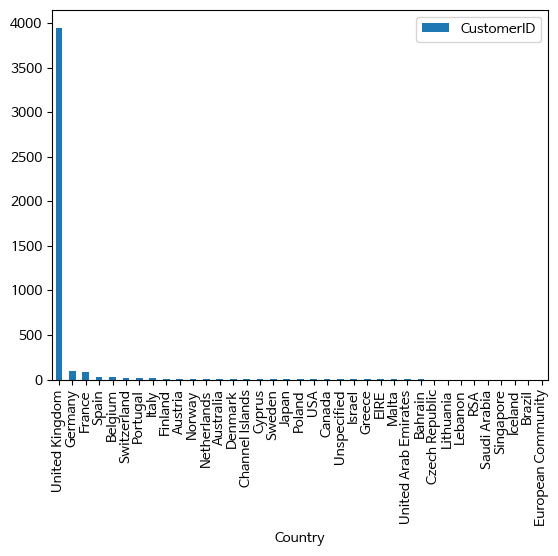

In [11]:
customer_country_count.plot(kind='bar', x='Country', y='CustomerID')
plt.show()

**결과** \
* 영국이 국적인 고객이 3950명으로 가장 많았으며, 독일이 고객인 사람이 95명으로 두번째로 많은 국적을 차지
* 가장 많은 국가와 두번째로 많은 국가의 차이가 많이 나타났으며, 이는 영국에 기반을 둔 온라인 소매업체의 거래 데이터를 사용하여 이러한 결과가 나타난 것으로 확인

## 2.2 Quantity

In [12]:
# Quantity 분포 확인
data['Quantity'].describe()

,Quantity
count,401604.000000
mean,12.183273
std,250.283037
min,-80995.000000
25%,2.000000
50%,5.000000
75%,12.000000
max,80995.000000


In [13]:
# Quantity가 음수인 데이터 확인
display(data[(data['Quantity']<0)].head(5))

# Quantity가 음수인 데이터 개수
print('Quantity가 음수인 데이터 개수 :', len(data[(data['Quantity']<0)]))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Quantity가 음수인 데이터 개수 : 8872


**결과** \
* Quantity는 거래건당 각 상품의 수량을 의미
* 분포를 확인해 본 결과 최소값이 -80995이고 최대값이 80995로 큰 차이를 보임
* 이때 최대값이 80995로 이상치로 판단하였지만 대량주문에 의한 것으로 보아 고객을 클러스터링 할 때 유용할 것으로 생각하여 제거를 안함
* Quantity는 수량을 의미하며, 음수의 값이 존재하는 것에 의문이 들어 살펴본 결과 InvoiceNo와 비교하여 판단한 결과 취소된 주문임을 알 수 있었음
* 취소된 주문 또한 고객을 분석 시 유용할 것으로 판단하여 제거를 안함

## 2.3 Invoice No

In [14]:
# 취소된 주문 확인 및 비율 계산
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [15]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

**결과**
* InvoiceNo는 각 트랜잭션에 고유하게 할당된 값이며, 문자 c로 시작하면 취소된 주문임을 의미
* 이를 이용해서 취소된 거래의 비율을 확인한 결과 약 16%로 상당한 규모를 보여줌
* 이는 거래를 자주 취소하는 집단이 있을 것으로 판단하여 추후 분석과 연관지어 생각

## 2.4 Stockcode

In [16]:
# StockCode 값의 길이 계산
data['len_StockCode'] = data['StockCode'].str.strip().str.len()
# StockCode 길이에 대한 빈도 수 비율 확인
data["len_StockCode"].value_counts(normalize=True)

,proportion
len_StockCode,
5,0.911791
6,0.082703
4,0.003028
1,0.001337
7,0.000737
2,0.000334
3,0.000040
12,0.000030


In [17]:
# 숫자를 제외한 Stockcode 추출
stockcode_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
stockcode_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [18]:
# 비정상적인 stockcode 제거
data = data[(data['len_StockCode'] >= 5) & (data['len_StockCode'] < 8)]
# 확인
print('Dataframe dimensions:', data.shape)

Dataframe dimensions: (399689, 9)


**결과**
* Stockcode는 각 제품에 할당된 고유한 5자리 정수를 의미
* Stockcode값의 길이를 측정하여 빈도 수의 비율을 확인한 결과 5자리를 제외한 여러개의 값이 있다는 것으로 나타났으며, 5자리 정수를 제외한 Stockcode값은 Post, D, C2, M, BANK CHARGES, PADS, DOT, CRUK가 존재함을 발견했다. 이는 5자리 정수로 구성된 Stockcode의 표준 형식에서 벗어나 있으므로 이상치로 판단했으며, 삭제하고 진행

## 2.5 Unit Prices

In [19]:
# Unit Prices 분포 확인
data['UnitPrice'].describe()

,UnitPrice
count,399689.000000
mean,2.907457
std,4.451881
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [20]:
# Quantity에 대한 Unit Prices가 0인 분포 확인
data[data['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000
std,2176.713608


In [21]:
# UnitPrice가 0인 데이터 확인
data[data['UnitPrice']==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647,Germany,5
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,5
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911,EIRE,5
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,5
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,5


In [22]:
# UnitPrice가 0인 값을 제거
data = data[data['UnitPrice'] > 0]

In [23]:
# RFM 분석에 앞서 최종데이터 구조 확인
print('Dataframe dimensions:', data.shape)

Dataframe dimensions: (399656, 9)


**결과**
* UnitPrice는 단위당 제품가격을 의미하며, 분포를 확인한 결과 최소값이 0인 것을 확인하였다.
* 제품가격이 0인 것을 이상하다고 생각하여, 제품가격 0일 때 Quantity의 분포를 확인하였다.
* 제품가격이 0인 거래는 33건으로 상대적으로 적었으며, 최소값 1, 최대값 12540, 표준편차 2176으로 관련 제품의 수량에 큰 변동성과 표준편차가 있다.
* 이는 분석에 포함하면 왜곡될 가능성이 있기 때문에 이상치로 판단하여 제거하였다.

# 3. 월별 매출과 MAU 확인

In [26]:
# 월별 매출과 MAU 확인을 위한 데이터 셋 생성
# 이때 취소 주문은 제외
check_data = data[data['Quantity'] > 0].copy()
check_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,6
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,6
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,6
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,6


In [27]:
# 년도 월 컬럼 생성
check_data['YearMonth'] = check_data['InvoiceDate'].dt.strftime('%Y-%m')
# 유저별 구매금액 Money 생성
check_data['Money'] = check_data['Quantity'] * check_data['UnitPrice']

In [28]:
# 월별 매출과 MAU 계산
revenue_mau = check_data.groupby('YearMonth', as_index=False)[['Money']].sum().rename(columns={'Money':'Revenue'})
mau_data = check_data.groupby('YearMonth', as_index=False)[['CustomerID']].nunique()
revenue_mau['MAU'] = mau_data['CustomerID']
# 2011-12-9까지 데이터이므로 12월 데이터 제거
revenue_mau.drop(index=12, axis=0, inplace=True)
revenue_mau

,YearMonth,Revenue,MAU
0,2010-12,565199.56,884
1,2011-01,562682.91,739
2,2011-02,442293.59,757
3,2011-03,583143.85,973
4,2011-04,454440.88,853
5,2011-05,659242.49,1054
6,2011-06,653264.92,990
7,2011-07,591603.79,946
8,2011-08,635514.38,933
9,2011-09,938752.63,1259


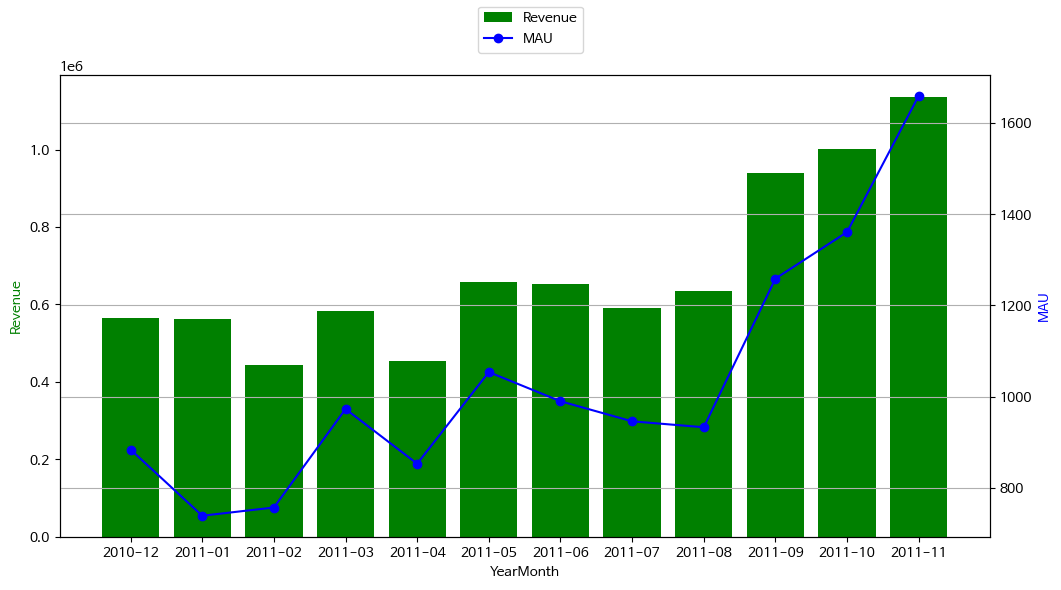

In [29]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax2 = ax1.twinx()
ax1.bar(revenue_mau['YearMonth'], revenue_mau['Revenue'], color='g', label='Revenue')
ax2.plot(revenue_mau['YearMonth'], revenue_mau['MAU'], color='b', label='MAU', marker='o')

ax1.set_xlabel('YearMonth')
ax1.set_ylabel('Revenue', color='g')
ax2.set_ylabel('MAU', color='b')


fig.legend(loc="upper center")

plt.grid()
plt.show()

In [30]:
revenue_3m = pd.DataFrame({'Month' : ['9months', '3months'], 'Revenue' : [revenue_mau[:-3]['Revenue'].mean(), revenue_mau[-3:]['Revenue'].mean()]})

In [31]:
display(revenue_3m)
a = revenue_3m[revenue_3m['Month'] == '9months']['Revenue'][0]
b = revenue_3m[revenue_3m['Month'] == '3months']['Revenue'][1]
up_num = round(((b-a)/a) * 100, 2)
print(f'증가률 : {up_num}%')

,Month,Revenue
0,9months,5.719318e+05
1,3months,1.025871e+06


증가률 : 79.37%


최근 2011-09 부터 2011-11월까지 매출과 MAU가 증가하고 있다, 원인을 파악해 매출증가의 이유를 찾는다

# 4. 고객 세그먼트

매출증가의 원인을 파악하기 위해 고객 세그먼트 진행
  * RFM는 Recency, Frequency, Monetary의 약자로 고객별로 얼마나 최근에, 얼마나 자주, 얼마나 많은 금액을 지출했는지에 따라 구매 패턴을 기준으로 고객 그룹을 분류하는 기법이다.
  * 새로운 데이터프레임에 기존 데이터로 Recency, Frequency, Monetary 열을 생성하여 분석을 진행하였다.


In [33]:
# 상품 수량과 상품 가격을 곱해 Monetary계산
data['Monetary'] = data['Quantity'] * data['UnitPrice']
# 데이터 세트의 마지막 날짜 +1해서 최근 날짜(일)계산
# 최근날짜랑 구매날짜를 빼서 최근 구매일 계산
current_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
data['Recency'] = (current_date - data['InvoiceDate']).dt.days
# 고객 ID별 Recency, Frequency, Monetary 계산
rfm_data = data.groupby('CustomerID').agg({'Recency':'min', # 고객별 가장 최근 구매일
                                           'InvoiceNo':'nunique', # 빈도별 고유거래수
                                           'Monetary':'sum' # monetary 합계
                                           })
# InvoiceNo -> Frequency rename
rfm_data.rename(columns={'InvoiceNo':'Frequency'}, inplace=True)

rfm_data.reset_index(inplace=True)
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12347,2,7,4310.00
2,12348,75,4,1437.24
3,12349,19,1,1457.55
4,12350,310,1,294.40


In [34]:
# 확인
print(data['CustomerID'].nunique())
print(rfm_data.shape)

4362
(4362, 4)


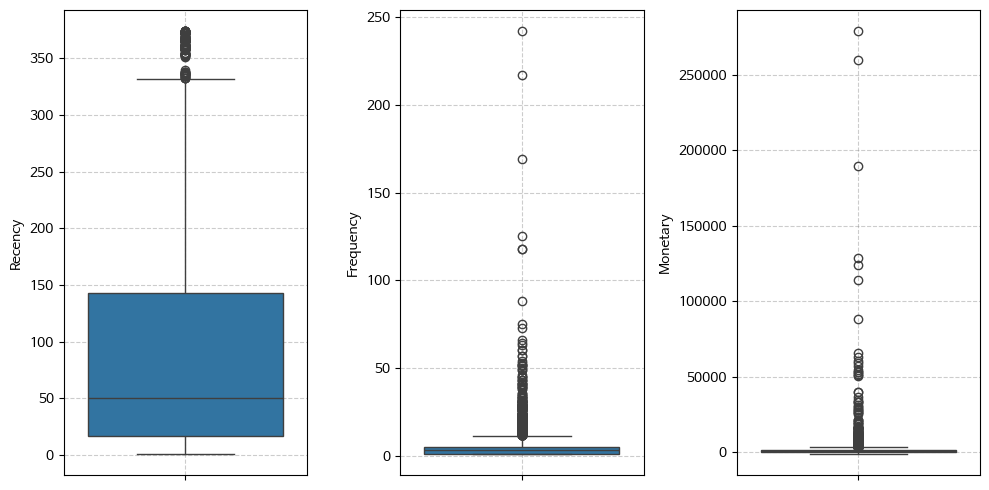

In [35]:
# Recency, Frequency, Monetary 분포 확인
rfm_list = ['Recency','Frequency','Monetary']
plt.figure(figsize=(10, 5))
for i, x in enumerate(rfm_list):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=rfm_data[x])
    plt.grid(color='gray', alpha=0.4, linestyle='--')
    plt.tight_layout()
plt.show()

In [37]:
# 이상치 제거
new_df = rfm_data[rfm_list]
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
# Z-Score >= 3인 데이터 제거
filtered_z_scores = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_z_scores]
# 확인
new_df.head()

,Recency,Frequency,Monetary
0,326,2,0.00
1,2,7,4310.00
2,75,4,1437.24
3,19,1,1457.55
4,310,1,294.40


* 박스플롯을 그려 Recency, Frequency, Monetary열의 이상치를 판별
* Frequency와 Monetary열에 이상치가 많이 있다는 것을 확인
* 자세하게 판단하기 위해 데이터 점이 평균에서 얼마나 떨어져 있는지 알려주는 Z-Score를 활용해서 Z-Score가 3이상인(3 표준편차) 데이터를 제거함

## 4.1 군집분석 K-means

생성된 Recency, Requency, Monetary 열을 사용하여 군집분석 진행

### 표준화

In [38]:
# 데이터 표준화
scaler = StandardScaler()
train_data = scaler.fit_transform(new_df)
# 확인
train_data

array([[ 2.30117909, -0.48033027, -0.65674115],
       [-0.90357602,  0.57619967,  1.50090696],
       [-0.181517  , -0.05771829,  0.06276191],
       ...,
       [-0.8442287 , -0.26902428, -0.56833264],
       [-0.88379358,  2.47795358,  0.36430199],
       [-0.49803602, -0.26902428,  0.2630277 ]])

### 엘보우 메서드

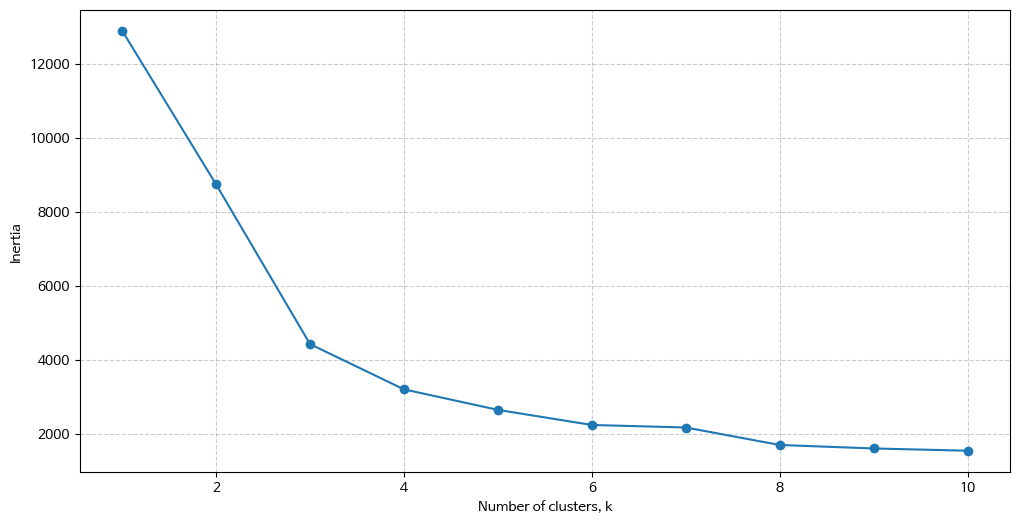

In [39]:
# 엘보우 메서드 수행
sse = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(train_data)
    sse.append(model.inertia_)
# 결과 확인
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.grid(color='gray', alpha=0.4, linestyle='--')
plt.show()

### K-Means 실행 후 결과 해석

In [40]:
# k:3로 KMeans 모델 설정
kmeans_m = KMeans(n_clusters=3, n_init='auto', random_state=1)
kmeans_m.fit(train_data)

KMeans(n_clusters=3, random_state=1)

In [41]:
# 실루엣 스코어 확인
silhouette_score(train_data, kmeans_m.labels_, metric='euclidean')

0.5176544439508075

In [42]:
# 예측 결과 저장
pred = kmeans_m.predict(train_data)
pred = pd.DataFrame(pred, columns=['cluster'])
result = pd.concat([new_df.reset_index(drop=True), pred], axis=1)
result['cluster'] = result['cluster'].astype('category')
result.head()

,Recency,Frequency,Monetary,cluster
0,326,2,0.00,0
1,2,7,4310.00,2
2,75,4,1437.24,2
3,19,1,1457.55,2
4,310,1,294.40,0


<ipython-input-43-5d2d5b6af4c2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = result.groupby(['cluster'], as_index=False).mean()


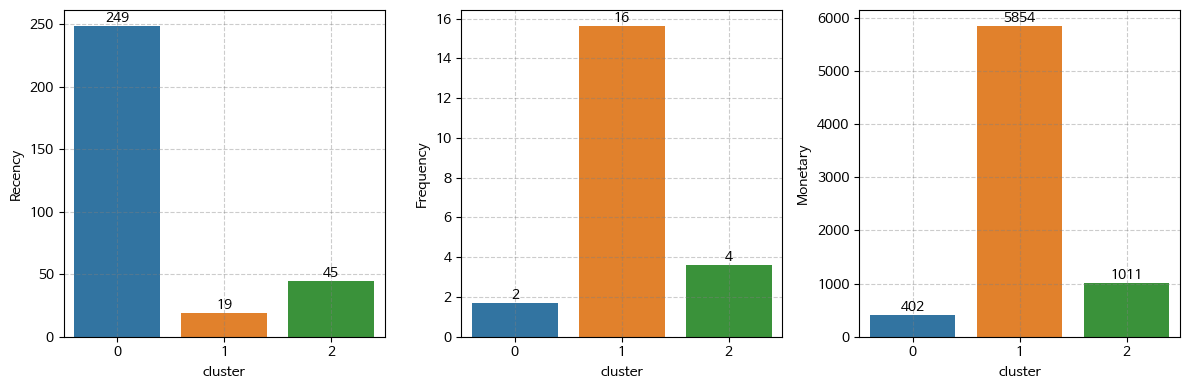

In [43]:
# 군집별 데이터 추출
temp = result.groupby(['cluster'], as_index=False).mean()
plt.figure(figsize=(12, 4))
for i, feature in enumerate(rfm_list):
    plt.subplot(1, 3, i+1)
    ax = sns.barplot(x='cluster', y=feature, data=temp, hue='cluster')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.f')
    plt.legend([],[], frameon=False)
    plt.grid(color='gray', alpha=0.4, linestyle='--')

plt.tight_layout()
plt.show()

- 군집 0은 평균 249일 전에 구매를 하였고 구매 빈도는 낮으며, 평균적으로 2회 구매였고 총 구매 금액도 비교적 낮다. 이들은 최근에 많이 구매하지 않았으며, 지출도 적은 고객들로 잠재적인 재활성화가 필요한 집단으로 보인다.
- 군집 1은 평균 19일 전에 구매를 하였고 구매 빈도가 매우 높으며, 평균적으로 16회 구매하였고 총 구매 금액도 매우 높다. 이들은 최근에 많이 구매하고 자주 구매하며 지출도 많은 서비스에 핵심 충성고객이므로 특별한 유지 관리를 제공해야 할 집단으로 보인다.
- 군집 2는 평균 45일 전에 구매를 하였고 구매 빈도가 중간으로 평균적으로 4회 구매하였고 총 구매 금액도 중간이다. 이들은 최근에 자주 구매하고 지출도 적당한 고객이므로 충성고객으로 전환시킬 마케팅이 필요해 보인다.


In [44]:
# 군집 이름 변경
# 군집 0 -> 이탈고객, 군집 1 -> 충성고객, 군집 2 -> 기존고객
result['cluster'] = result['cluster'].replace({0:'이탈고객', 1:'충성고객', 2:'기존고객'})

# 군집별 인원수와 비율 확인
group_counts = result.groupby('cluster').size().reset_index(name='Count')
group_counts['Ratio'] = group_counts['Count'] / len(result) * 100
group_counts

<ipython-input-44-939bbde31528>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  result['cluster'] = result['cluster'].replace({0:'이탈고객', 1:'충성고객', 2:'기존고객'})
<ipython-input-44-939bbde31528>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = result.groupby('cluster').size().reset_index(name='Count')


,cluster,Count,Ratio
0,이탈고객,1074,24.988367
1,충성고객,402,9.353188
2,기존고객,2822,65.658446


In [45]:
# 각 고객 그룹별 매출 비율
group_money = result.groupby('cluster')[['Monetary']].sum().reset_index()
group_money['Ratio'] = (group_money['Monetary'] / result['Monetary'].sum()) * 100
group_money

<ipython-input-45-b967b5377c60>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_money = result.groupby('cluster')[['Monetary']].sum().reset_index()


,cluster,Monetary,Ratio
0,이탈고객,432209.19,7.665433
1,충성고객,2353336.99,41.737538
2,기존고객,2852872.12,50.597029


In [93]:
# 각 고객 그룹별 객단가
group_money['ARPPU'] = group_money['Monetary'] / group_counts['Count']
group_money[['cluster', 'ARPPU']]

,cluster,ARPPU
0,이탈고객,402.429413
1,충성고객,5854.072114
2,기존고객,1010.939802


* 충성고객은 10%, 이탈고객은 25%, 기존고객은 65%
* 이때 매출은 충성고객 41%, 이탈고객 7%, 기존고객 50%
* 확인한 인사이트
    * 고객 전체의 **10%**에 불과한 충성고객이 전체 매출의 **41%**를 차지함
    * 또한, 충성고객의 객단가가 5854로 기존 고객 층의 약 4배
    * 이는 충성고객이 다른 고객군에 비해 높은 매출과 객단가을 보유
    * 즉, 충성고객의 구매 행동은 매출 증가에 큰 영향을 미침
* 목표
    * 충성고객의 특성을 파악하여 기존 고객을 충성고객으로 전환할 수 있는 전략 설계

# 5. 충성고객 특성 파악

In [47]:
# 특징을 파악하기 위한 군집결과를 처음 데이터로 삽입
temp = pd.concat([new_df, rfm_data['CustomerID']], axis=1)
temp = temp.dropna().reset_index(drop=True)
temp = pd.concat([temp, result['cluster']], axis=1)
cluster_data = data.copy()
cluster_data = pd.merge(cluster_data, temp[['CustomerID', 'cluster']])
cluster_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,len_StockCode,Monetary,Recency,cluster
0,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,5,54.08,374,충성고객
1,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,5,12.60,374,충성고객
2,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,5,12.60,374,충성고객
3,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047,United Kingdom,5,30.00,374,충성고객
4,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047,United Kingdom,5,9.90,374,충성고객


### 구매 패턴 비교 분석 - 코호트

In [49]:
from operator import attrgetter
def CohortRetention(dataframe, name):
    df = dataframe.copy()
    df = df[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
    # 최근 구매달 계산
    df['order_month'] = df['InvoiceDate'].dt.to_period('M')
    # 코흐트 계산
    df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
    # 코흐트, 월별 고객 수 집계
    cohort_data = df.groupby(['CohortMonth', 'order_month']).agg({
        'CustomerID':'nunique'
    }).reset_index(drop=False)
    cohort_data.rename(columns={'CustomerID' : 'n_customers'}, inplace=True)
    # 각 코흐트별 몇 개월이 지났는지 계산
    cohort_data['period_number'] = (cohort_data['order_month'] - cohort_data['CohortMonth']).apply(attrgetter('n'))
    # 피벗 테이블 생성
    cohort_table = cohort_data.pivot_table(index='CohortMonth', columns='period_number', values='n_customers')
    # 리텐션 계산
    cohort_size = cohort_table.iloc[:, 0]
    cohort_table_retention = cohort_table.divide(cohort_size, axis=0)
    # 월별 유입 고객 수 확인
    display(cohort_size.to_frame('cohort_size').astype('int').T)

    # 코흐트 히트맵 생성
    plt.figure(figsize=(12, 8))
    sns.heatmap(cohort_table_retention, annot=True, fmt='.0%', cmap='coolwarm', cbar=False)
    plt.title(f'Monthly Cohorts : {name} Retention')
    plt.xlabel('Months since Purchase')
    plt.ylabel('Purchase Month')
    plt.show()


CohortMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-09,2011-10,2011-11,2011-12
cohort_size,238,63,28,40,7,9,9,3,1,2,1,1


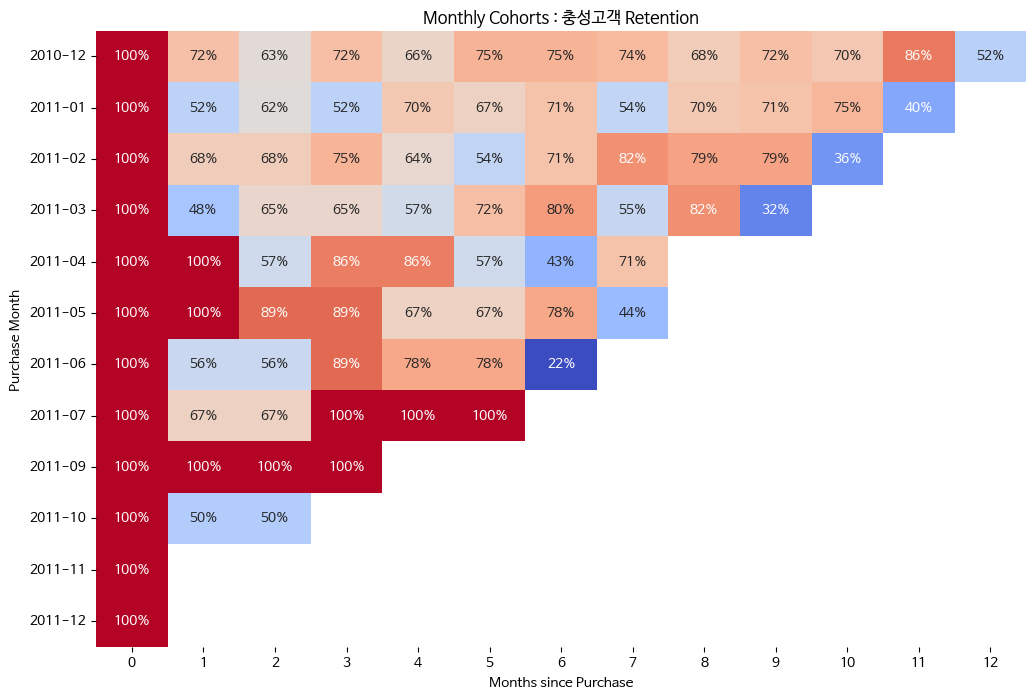

In [50]:
loyal_cluster_data = cluster_data[cluster_data['cluster']=='충성고객'].copy()
CohortRetention(loyal_cluster_data, '충성고객')

CohortMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
cohort_size,657,349,350,398,290,270,225,183,166,298,351,319,40


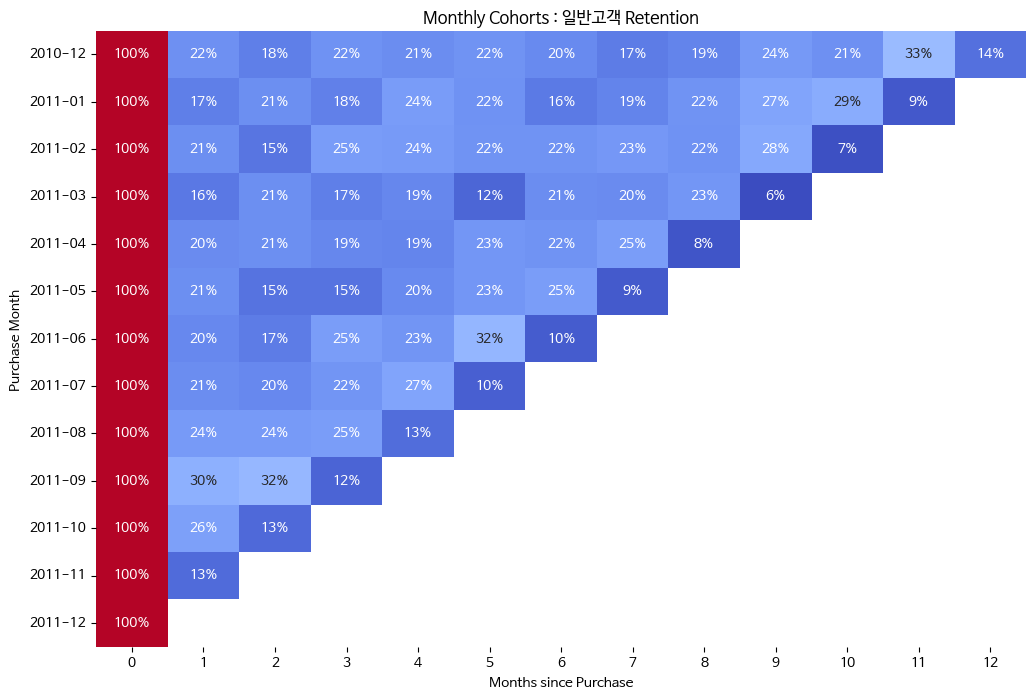

In [51]:
standard_cluster_data = cluster_data[cluster_data['cluster'] != '충성고객'].copy()
CohortRetention(standard_cluster_data, '일반고객')

In [88]:
# 충성고객 평균 구매 간격
# 고객별 첫 구매일과 마지막 구매일 계산
first_last_purchase = loyal_cluster_data.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

# 고객별 주문 건수 계산
order_counts = loyal_cluster_data.groupby('CustomerID').size()

# 고객당 평균 구매 간격 계산: (마지막 구매일 - 첫 구매일) / (주문 건수 - 1)
first_last_purchase['avg_purchase_interval'] = (pd.to_datetime('2012-09') - first_last_purchase['min']).dt.days / (order_counts - 1)

# 결과 출력
print(first_last_purchase[['avg_purchase_interval']].mean())

avg_purchase_interval    4.617746
dtype: float64


In [85]:
# 일반고객 평균 구매간격
# 고객별 첫 구매일과 마지막 구매일 계산
first_last_purchase = standard_cluster_data.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])

# 고객별 주문 건수 계산
order_counts = standard_cluster_data.groupby('CustomerID').size()

# 고객당 평균 구매 간격 계산: (마지막 구매일 - 첫 구매일) / (주문 건수 - 1)
first_last_purchase['avg_purchase_interval'] = (pd.to_datetime('2012-09') - first_last_purchase['min']).dt.days / (order_counts - 1)

# 주문 건수가 1인 고객에 대해 NaN을 0으로 처리
first_last_purchase['avg_purchase_interval'] = first_last_purchase['avg_purchase_interval'].replace([float('inf'), -float('inf')], float('nan'))
first_last_purchase['avg_purchase_interval'] = first_last_purchase['avg_purchase_interval'].fillna(0)

# 결과 출력
print(first_last_purchase[['avg_purchase_interval']].mean())

avg_purchase_interval    31.604475
dtype: float64


구매 패턴 비교 분석 결과

1. 충성고객 코호트의 구매 빈도
* 충성고객 코호트는 구매 빈도가 높으며, 특히 초기 구매 월 이후 2~3개월 동안 높은 재구매 비율을 유지
    * 2011-05 충성고객 코호트는 첫 구매 이후 2개월 동안 89% 이상의 유지율을 기록, 이는 매달 꾸준히 상품을 구매했음을 시사
* 일반 고객 코호트는 첫 구매 이후 빠르게 구매 빈도가 줄어들며, 2개월 이후 대부분의 고객이 재구매하지 않는 패턴이 보임
    * 2011-05 일반 고객 코호트는 2개월 차에 유지율이 15%로 급격히 하락

2. 충성고객의 평균 구매 간격
* 충성고객 평균 구매 주기는 평균 4일로 매출에 지속적인 기여를 함
* 일반 고객은 평균 구매 주기는 평균 30일로 매출 기여도가 낮음

3. 코호트별 매출 기여도
* 충성고객 코호트는 매출의 41%를 차지하며, 매출 성장세가 일반 고객에 비해 높음
    * 충성고객은 10%의 비율로 전체 고객에서 차지하는 비중이 작지만, 전체 매출의 41%를 기여
* 일반 고객은 구매율이 낮고 매출 기여도가 59%로 낮음
    * 일반 고객은 전체 고객의 90%를 차지하지만 매출 기여도는 59%에 그침
* 특정 충성고객 코호트는 시간이 지나도 매출 성장세를 유지하는 반면, 일반 고객 코호트는 시간이 지나며 매출 기여도가 급격히 감소

4. 충성고객 코호트와 일반 고객 코호트의 매출 패턴 비교
* 충성고객 코호트
    * 높은 초기 유지율과 지속적인 구매로 인해 장기적인 매출 성장에 기여
	* 2011-05 코호트는 5개월 차에도 유지율 67%를 기록, 매출 기여도가 꾸준히 유지됨
* 일반 고객 코호트
	* 초기 매출 기여도는 있지만, 구매가 빠르게 감소하며 장기적인 매출에는 큰 영향을 미치지 않음
	* 2011-05 코호트는 2개월 차 이후 매출 기여도가 거의 없으며, 장기적인 매출 성장에 기여하지 못함

**결론**
* 충성고객 코호트는 재구매 행동과 높은 유지율을 통해 장기적인 매출 성장의 핵심 원동력이 됨
* 일반 고객 코호트는 초기 매출 창출에는 기여하지만, 장기적인 매출 성장에는 크게 기여하지 못함
* 따라서 충성고객의 구매 패턴을 이해하고, 이들 고객의 지속적인 만족과 재구매를 유도하는 전략이 필요     
    * 충성고객 맞춤형 추천 시스템, 장기적인 고객 유지를 위한 로열티 프로그램 등을 고려할 수 있음